#### Loading packages

In [1]:
%load_ext autoreload
%autoreload 2

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from skimage.draw import disk, ellipse, rectangle
from skimage.io import imshow, imsave
from tqdm.auto import tqdm

from PyPlaque.experiment import ExperimentFluorescencePlaque
from PyPlaque.utils import picks_area, picks_perimeter
from PyPlaque.view import  WellImageReadout


/Users/de29/Applications/miniforge3/envs/pyplaque/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Generate Synthetic Images
###### The following functions help us generate synthetic objects on ```(2048, 2048)``` resolution images with objects in white foreground against a black background.<br>```check_overlap``` checks whether two synthetic objects overlap each other from their centres and minimum allowable distance between them.<br>```generate_shapes``` generates the images based on parameters such as circle_radius=50, ellipse_width=100, ratio=0.5, square_side=100 set to these default values but can be changed by user. Please make sure to provide seed to achieve reproducible results and path to save the generated images. Along with the images is generated a list of dictionaries with the 'Area', 'Centroid_X', 'Centroid_Y' and 'Perimeter' corresponding to each shape in each image.


In [2]:
def check_overlap(center1, center2, distance):
    return np.sqrt(np.sum((np.array(center1) - np.array(center2)) ** 2)) < distance


def ellipse_perimeter(a, b):
    """
    Calculate the perimeter of an ellipse using Ramanujan's approximation.
    
    Parameters:
    - a: Semi-major axis of the ellipse
    - b: Semi-minor axis of the ellipse
    
    Returns:
    - The approximate perimeter of the ellipse
    """
    return math.pi * (3*(a + b) - math.sqrt((3*a + b) * (a + 3*b)))


def generate_shapes(circle_radius=50, ellipse_width=100, ratio=0.5, overlap_distance=None,
                                                        square_side=100, path=None, seed=None):

    if seed is not None:
        random.seed(seed) 

    img = np.zeros((2048, 2048), dtype=np.uint16)  # Create a black 16-bit grayscale image
    ground_truth = [] 

    # Generate 1 circle
    center = [random.randint(circle_radius, 2048-circle_radius), 
                    random.randint(circle_radius, 2048-circle_radius)]  # Randomly specify center
    rr, cc = disk(center, circle_radius)
    img[rr, cc] = 65535
    ground_truth.append({'Area': math.pi * circle_radius ** 2, 'Centroid_Y': center[0],
                                'Centroid_X': center[1], 'Perimeter': 2 * math.pi * circle_radius})  

    # Generate 1 ellipse with specified eccentricity
    height = ellipse_width * ratio
    center_ellipse = [random.randint(ellipse_width//2, 2048-ellipse_width//2), 
                            random.randint(height//2, 2048-height//2)]  # Randomly specify center
    while check_overlap(center, center_ellipse, circle_radius + max(ellipse_width//2, height//2)):  
        # Ensure the ellipse does not overlap with the circle
        center_ellipse = [random.randint(ellipse_width//2, 2048-ellipse_width//2), 
                                                        random.randint(height//2, 2048-height//2)]
    rr, cc = ellipse(center_ellipse[0], center_ellipse[1], ellipse_width//2, height//2)
    img[rr, cc] = 65535
    ground_truth.append({ 'Area': math.pi * (ellipse_width//2) * (height//2),
                                'Centroid_Y': center_ellipse[0], 'Centroid_X': center_ellipse[1],
                                'Perimeter':ellipse_perimeter(ellipse_width//2, height//2)})  

    # Generate 1 square
    start = (random.randint(0, 2048-square_side), random.randint(0, 2048-square_side))  
    # Randomly specify start
    while check_overlap(center, start, circle_radius + square_side) or 
    check_overlap(center_ellipse, start, max(ellipse_width//2, height//2) + square_side):  
    # Ensure the square does not overlap with the circle or the ellipse
        start = (random.randint(0, 2048-square_side), random.randint(0, 2048-square_side))
    rr, cc = rectangle(start, extent=(square_side, square_side))
    img[rr, cc] = 65535
    ground_truth.append({'Area': square_side**2, 'Centroid_Y':(start[0]+square_side//2),
        'Centroid_X':(start[1]+square_side//2), 'Perimeter':square_side*4})  # Add to ground truth
    
    # Add 2 overlapping circles

    if overlap_distance == None:
        overlap_distance = circle_radius // 2 
         
    center1 = np.array([random.randint(circle_radius, 2048-circle_radius-2*overlap_distance), 
                            random.randint(circle_radius, 2048-circle_radius-2*overlap_distance)])
    center2 = center1 + np.array([overlap_distance, overlap_distance])  
    # Calculate the center of the second circle based on the overlap distance
    while check_overlap(center, center1, 2 * circle_radius) or 
        check_overlap(center_ellipse, center1, max(ellipse_width//2, height//2) + circle_radius) or 
        check_overlap(center, center2, 2 * circle_radius) or 
        check_overlap(center_ellipse, center2, max(ellipse_width//2, height//2) + circle_radius) or 
        check_overlap(start, center1, square_side + circle_radius) or 
        check_overlap(start, center2, square_side + circle_radius):  
        # Ensure the overlapping circles do not overlap with the single circle, the ellipse, or 
        # the square
        center1 = np.array([random.randint(circle_radius, 2048-circle_radius), 
                                                random.randint(circle_radius, 2048-circle_radius)])
        center2 = center1 + np.array([overlap_distance, overlap_distance])
    rr, cc = disk(center1, circle_radius)
    img[rr, cc] = 65535
    rr, cc = disk(center2, circle_radius)
    img[rr, cc] = 65535
#######
    # Calculate the perimeter of each circle
    perimeter_each_circle = 2 * math.pi * circle_radius

    # Calculate the arc length in radians
    arc_length_rad = 2 * math.acos((circle_radius - overlap_distance) / circle_radius)

    # Convert the arc length to length units
    arc_length = arc_length_rad * circle_radius

    # Calculate the total perimeter of the overlapping circles
    total_perimeter = 2 * perimeter_each_circle - 2 * arc_length
    
    # Calculate the area of each sector
    area_each_sector = (arc_length_rad / (2 * math.pi)) * math.pi * circle_radius**2

    area_each_triangle = (circle_radius**2 / 2) * math.sin(arc_length_rad)

    area_each_circle = math.pi * circle_radius**2

    area_overlap = 2 * area_each_sector - 2 * area_each_triangle

    # Calculate the total area of the two circles including the overlapping region
    total_area = 2 * area_each_circle - area_overlap

    ground_truth.append({'Area': total_area, 'Centroid_Y': [(center1 + center2) / 2][0][0],
        'Centroid_X': [(center1 + center2) / 2][0][1], 'Perimeter':total_perimeter})  
        # Add to ground truth
    imshow(img, cmap='gray')
    if path!=None:
        imsave(path, img)

    # Generate ground truth
    

    return img, ground_truth

#### Generate synthetic images and ground truth measurements
###### Here the actual images are generated by calling the functions above using specific paramters for the shapes and seed. The files are named as ```A0{i}_w2.TIF```, ```i``` being the ith image starting from 1 through 6 (so 5 images in all). The ground truth (gt) obtained from the generating function is saved as a dataframe and can be saved optionally for comparison with other methods later on.

            Area  Centroid_Y  Centroid_X    Perimeter
0   70685.834706       425.0      1315.0   942.477796
1   28274.333882      1885.0      1703.0   690.384369
2  160000.000000      1764.0       329.0  1600.000000
3  113733.351193       709.5       428.5  1256.637061
4   70685.834706      1888.0       265.0   942.477796


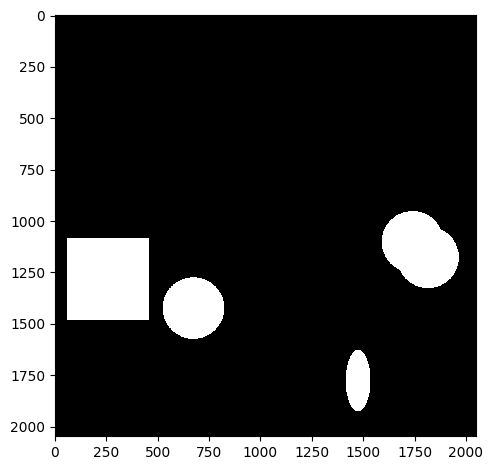

In [3]:
# Generate 5 images and ground truth
data=[]

for i in range(1, 6):
    img, gt = generate_shapes(circle_radius=150, ellipse_width=300, ratio=0.4, square_side=400,
                                                                                        seed=i)
    filename = f"A0{i}_w2.TIF"
    data.extend(gt) 
    # imsave(filename, img)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)
print(df.head())

# Order columns
df= df[['Area', 'Centroid_X', 'Centroid_Y', 'Perimeter']]

# Optionally, save the DataFrame to a CSV file
# df.to_csv("gt_res.csv", index=False)

#### Generate PyPlaque measurements on the synthetic images
###### Since we would now like to compare the readouts from PyPlaque to other methods, we treat the synthetic images as wells of a plate and define a new ```ExperimentFluorescencePlaque``` class instance to work with them.<br>Using ```exp.get_individual_plates()``` we get the individual plate and plate mask folders for the given pattern and ```exp.get_number_of_plates()``` gives us the number of plates found according to pattern, here just 1.<br>```exp.load_wells_for_plate_virus()``` helps us load into memory all data corresponding to the index of the plates found ```plate_id```, file pattern ```file_pattern``` and file extension ```ext```. Here the synthetic images are read as images and the masks path is empty and therefore masks are generated at runtime, but it does not matter since we do not need both specifically for this task. We also use the virus channel here since this shapes are larger filled objects which are more likely for to resemble the virus channel than the nuclei.

In [4]:
base_dir = '../../../../data_backup/synthetic_images/'
exp = ExperimentFluorescencePlaque(base_dir+'images', base_dir+'masks', params = None) 
# default values in class, option to update

#In this case, the synthetic plate have 5 wells filled with synthetic shapes
plate_dirs, plate_mask_dirs = exp.get_individual_plates(folder_pattern=r'^synthetic')

print(plate_dirs, plate_mask_dirs)

#We are choosing via the pattern above to ignore all other plates other than this one
print(exp.get_number_of_plates())

['synthetic_plate'] ['synthetic_plate']
1


In [5]:
plate_dict_synthetic_w2 = exp.load_wells_for_plate_virus(plate_id=0, additional_subfolders=None,
                                                                file_pattern=r'_w2', ext='*.TIF')
print(plate_dict_synthetic_w2.keys())

5it [00:00, 12818.78it/s]
100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

dict_keys(['synthetic_plate'])


../../../../data_backup/synthetic_images/images/synthetic_plate/A03_w2.TIF


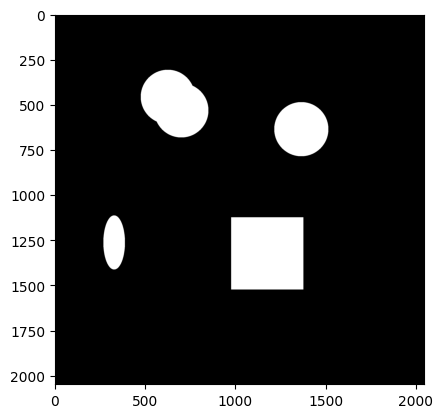

In [6]:
# Sample of an image name and image from the loaded dictionary of data plate_dict_synthetic_w2
print(plate_dict_synthetic_w2[plate_dirs[0]]['image_name'][2])
plt.imshow(plate_dict_synthetic_w2[plate_dirs[0]]['img'][2], cmap='gray')

###### Verifying the number of images and corresponding data loaded into the dictionary by ```exp.load_wells_for_plate_virus()```

In [7]:
print(len(plate_dict_synthetic_w2[plate_dirs[0]]['img']))

5


###### Iterating through all the images and masks in ```plate_dict_synthetic_w2```. We instantiate an instance of class ```WellImageReadout``` for every image, treating the image as both the nuclei and plaque image, also the same mask as nuclei and plaque mask. We then extract all the plaque objects and provided that at least 1 plaque is found, get the area and perimeter for each shape using ```Pick's theorem```. Centroid_X and Centroid_Y are no different than the other methods. We once again create a dataframe of this output like the ground_truth and have the option to save it for future use.

In [8]:
d = plate_dirs[0]
output = []
pad = 10
for i in tqdm(range(len(plate_dict_synthetic_w2[d]['img']))):
    plq_image_readout = WellImageReadout(nuclei_image_name=str(plate_dict_synthetic_w2[d]
                                        ['image_name'][i]).split("/")[-1],
                plaque_image_name=str(plate_dict_synthetic_w2[d]['image_name'][i]).split("/")[-1],
                nuclei_image=np.array(plate_dict_synthetic_w2[d]['img'][i]),
                plaque_image=np.array(plate_dict_synthetic_w2[d]['img'][i]),
                nuclei_mask=np.array(plate_dict_synthetic_w2[d]['mask'][i]),
                plaque_mask=np.array(plate_dict_synthetic_w2[d]['mask'][i]),
                virus_params=exp.params['virus'])

    plq_objects = plq_image_readout.get_plaque_objects()

    if len(plq_objects) != 0:
        plq_object_readouts = [plq_image_readout.call_plaque_object_readout(plq_object,
                                                                exp.params['virus']) 
                                                                for plq_object in plq_objects]
        for plq_object_readout in plq_object_readouts:
            data = {
                        'Area': picks_area(plate_dict_synthetic_w2[d]['img'][i]
                        [(plq_object_readout.get_bbox()[0]-pad) : 
                        (plq_object_readout.get_bbox()[0]+plq_object_readout.get_bbox()[2]+pad),
                        (plq_object_readout.get_bbox()[1]-plq_object_readout.get_bbox()[3]-pad) : 
                        (plq_object_readout.get_bbox()[1]+pad)]),
                        'Centroid_X': plq_object_readout.get_centroid()[1], 
                        'Centroid_Y': plq_object_readout.get_centroid()[0],
                        'Perimeter': picks_perimeter(plate_dict_synthetic_w2[d]
                        ['img'][i][(plq_object_readout.get_bbox()[0]-pad) : 
                        (plq_object_readout.get_bbox()[0]+plq_object_readout.get_bbox()[2]+pad),
                        (plq_object_readout.get_bbox()[1]-plq_object_readout.get_bbox()[3]-pad) : 
                        (plq_object_readout.get_bbox()[1]+pad)]),
                    }
                
            output.append(data)


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


In [9]:
# Create a DataFrame from the list of dictionaries
output_df = pd.DataFrame(output)

# Save the DataFrame to a CSV file
# output_df.to_csv("../../../../data_backup/synthetic_images/pyplaque_res_picks.csv", index=False)

print(output_df)

        Area  Centroid_X  Centroid_Y    Perimeter
0    69812.0      1315.0       425.0   988.000000
1   100779.0       428.5       709.5  1238.828427
2   158403.0       328.5      1763.5  1604.000000
3    27588.0      1703.0      1885.0   704.000000
4    27588.0       233.0       337.0   704.000000
5   100779.0       702.5       818.5  1238.828427
6   158403.0      1570.5      1706.5  1604.000000
7    69812.0       265.0      1888.0   988.000000
8   100779.0       661.5       495.5  1238.828427
9    69812.0      1363.0       637.0   988.000000
10   27588.0       327.0      1264.0   704.000000
11  158403.0      1174.5      1324.5  1604.000000
12   27588.0      1537.0       361.0   704.000000
13  158403.0       383.5       516.5  1604.000000
14   69812.0       771.0       633.0   988.000000
15  100779.0      1312.5      1009.5  1238.828427
16  100779.0      1776.5      1140.5  1238.828427
17  158403.0       258.5      1284.5  1604.000000
18   69812.0       673.0      1425.0   988.000000


#### Compare readouts
###### Here we read the dataframes (named accordingly) corresponding to each method of calculating the area and perimeter of the shapes. Please note that scikit_image_df and pyplaque_df can both be generated by PyPlaque by using the appropriate flags.<br>Each of the dataframes have 20 rows (5 images and 4 objects in each, 1 of each category). We would now need to average metrics over these 5 images for each shape. For this we first sort the read dataframes by Area, Centroid_X and Centroid_Y. This works since the objects have an explicit ordering based on Area and the 5 circles for eg. in all 5 images will be clustered together and so on. We reset the index and get groups by doing integer division by 5 so that {0, ..., 4} are mapped to 0, {5, ..., 9} are mapped to 1 and so on. Then we can do groupby on resulting dataframe and calculate the ```mean()``` and ```std()```.

In [10]:
gt_df = pd.read_csv("../../../../data_backup/synthetic_images/gt_res.csv")
pyplaque_df = pd.read_csv("../../../../data_backup/synthetic_images/pyplaque_res_picks.csv")
scikit_image_df = pd.read_csv("../../../../data_backup/synthetic_images/pyplaque_res.csv")
matlab_df = pd.read_csv("../../../../data_backup/synthetic_images/matlab_res.csv")
fiji_df = pd.read_csv("../../../../data_backup/synthetic_images/fiji_res.csv")   

# Each of these have 20 rows (5 images and 4 objects in each, 1 of each category)
# We now need to consolidate metrics over these 4 object categories from the 5 images
gt_df = gt_df.sort_values(by=['Area', 'Centroid_X', 'Centroid_Y'], ascending=[True, True, True])
pyplaque_df = pyplaque_df.sort_values(by=['Area', 'Centroid_X', 'Centroid_Y'], 
                                                                ascending=[True, True, True])
scikit_image_df = scikit_image_df.sort_values(by=['Area', 'Centroid_X', 'Centroid_Y'], 
                                                                ascending=[True, True, True])
matlab_df = matlab_df.sort_values(by=['Area', 'Centroid_X', 'Centroid_Y'], 
                                                                ascending=[True, True, True])
fiji_df = fiji_df.sort_values(by=['Area', 'Centroid_X', 'Centroid_Y'], 
                                                                ascending=[True, True, True])

# indices here are indicative of the shapes, so 0-3 inclusive are shapes in synthetic image #1, 
# 4-7 in synthetic image #2 and so on
# Now we use the integer division of indices to get all row indices corresponding to one 
# shape to a single value

gt_df = gt_df.reset_index(drop=True)
pyplaque_df = pyplaque_df.reset_index(drop=True)
scikit_image_df = scikit_image_df.reset_index(drop=True)
matlab_df = matlab_df.reset_index(drop=True)
fiji_df = fiji_df.reset_index(drop=True)

average_gt_df = gt_df.groupby(gt_df.index // 5).mean().drop(columns=['Centroid_X', 'Centroid_Y'])
average_pyplaque_df = pyplaque_df.groupby(pyplaque_df.index // 5).mean().drop(
                                                            columns=['Centroid_X', 'Centroid_Y'])
average_scikit_image_df = scikit_image_df.groupby(scikit_image_df.index // 5).mean().drop(
                                                            columns=['Centroid_X', 'Centroid_Y'])
average_matlab_df = matlab_df.groupby(matlab_df.index // 5).mean().drop(
                                                            columns=['Centroid_X', 'Centroid_Y'])
average_fiji_df = fiji_df.groupby(fiji_df.index // 5).mean().drop(
                                                            columns=['Centroid_X', 'Centroid_Y'])

average_gt_df = average_gt_df.sort_values(by=['Area', 'Perimeter'], ascending=[True, True])
average_pyplaque_df = average_pyplaque_df.sort_values(by=['Area', 'Perimeter'], 
                                                                    ascending=[True, True])
average_scikit_image_df = average_scikit_image_df.sort_values(by=['Area', 'Perimeter'], 
                                                                    ascending=[True, True])
average_matlab_df = average_matlab_df.sort_values(by=['Area', 'Perimeter'], ascending=[True, True])
average_fiji_df = average_fiji_df.sort_values(by=['Area', 'Perimeter'], ascending=[True, True])

std_gt_df = gt_df.groupby(gt_df.index // 5).std().drop(columns=['Centroid_X', 'Centroid_Y'])
std_pyplaque_df = pyplaque_df.groupby(pyplaque_df.index // 5).std().drop(
                                                        columns=['Centroid_X', 'Centroid_Y'])
std_scikit_image_df = scikit_image_df.groupby(scikit_image_df.index // 5).std().drop(
                                                        columns=['Centroid_X', 'Centroid_Y'])
std_matlab_df = matlab_df.groupby(matlab_df.index // 5).std().drop(
                                                        columns=['Centroid_X', 'Centroid_Y'])
std_fiji_df = fiji_df.groupby(fiji_df.index // 5).std().drop(columns=['Centroid_X', 'Centroid_Y'])


###### A look at the dataframes after averaging across 5 images for each shape. Here the row indices correspond to the different shapes, ellipse, circle, overlapping circles and square with IDs, 0, 1, 2, and 3 respectively.

In [11]:
print('GT:')
print(average_gt_df)
print('PYPLAQUE:')
print(average_pyplaque_df)
print('SCIKIT-IMAGE:')
print(average_scikit_image_df)
print('MATLAB:')
print(average_matlab_df)
print('FIJI:')
print(average_fiji_df)

GT:
            Area    Perimeter
0   28274.333882   690.384369
1   70685.834706   942.477796
2  113733.351193  1256.637061
3  160000.000000  1600.000000
PYPLAQUE:
       Area    Perimeter
0   27588.0   704.000000
1   69812.0   988.000000
2  100779.0  1238.828427
3  158403.0  1604.000000
SCIKIT-IMAGE:
       Area    Perimeter
0   28233.0   721.872150
1   70661.0   990.489465
2  101806.0  1219.023520
3  160000.0  1596.000000
MATLAB:
       Area  Perimeter
0   28233.0    686.456
1   70661.0    939.000
2  101806.0   1155.220
3  160000.0   1563.716
FIJI:
       Area  Perimeter
0   28233.0    722.943
1   70661.0    991.561
2  101806.0   1218.923
3  160000.0   1597.657


/var/folders/ww/drh8wc992nxcqb4z8dmykc440000gn/T/ipykernel_71611/2734948987.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dfs.iloc[i]['Area_Group'] = group_num
/var/folders/ww/drh8wc992nxcqb4z8dmykc440000gn/T/ipykernel_71611/2734948987.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dfs.iloc[i]['Area_Group'] = group_num
